<a href="https://colab.research.google.com/github/MOsamaAS/CognoRise-InfoTech/blob/main/CXR%20Classification%20using%20VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Base Setup**

Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

Assign Directories

In [2]:
# Define directories for training and validation sets
train_dir = '/content/drive/MyDrive/X-AI/Train [Sub-Optimal]'
validation_dir = '/content/drive/MyDrive/X-AI/Validation'

Training Dataset Augmentations

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

Validation Dataset Augmentations

In [4]:
validation_datagen = ImageDataGenerator(rescale=1./255)

Generators

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Ensure this is still categorical
    classes=['COVID', 'Normal', 'Viral Pneumonia']  # Update the class names
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Ensure this is still categorical
    classes=['COVID', 'Normal', 'Viral Pneumonia']  # Update the class names
)

Found 750 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


# Model

VGG16

In [6]:
from keras.regularizers import l2
from keras.layers import Dropout

# Define the base model
# Define the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Optional: Add dropout for regularization
x = Dense(3, activation='softmax')(x)  # Change output units to 3

model = Model(inputs=base_model.input, outputs=x)
# Compile the model with accuracy and loss metrics
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])  # Add other metrics if needed

Model Summary

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Model Extraction Setup

Identification of Model Weights with Peak Performance

In [8]:
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import Callback

class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, monitor_acc='val_accuracy', monitor_loss='val_loss', verbose=1, acc_threshold=0.95):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor_acc = monitor_acc
        self.monitor_loss = monitor_loss
        self.verbose = verbose
        self.best_acc = -np.Inf
        self.best_loss = np.Inf
        self.acc_threshold = acc_threshold
        self.history = []  # To store epoch data

    def on_epoch_end(self, epoch, logs=None):
        current_acc = logs.get(self.monitor_acc)
        current_loss = logs.get(self.monitor_loss)

        # Save the current epoch data
        self.history.append({
            'epoch': epoch + 1,
            'accuracy': logs.get('accuracy'),
            'val_accuracy': logs.get('val_accuracy'),
            'loss': logs.get('loss'),
            'val_loss': logs.get('val_loss')
        })

        # Check if the validation accuracy is less than the threshold
        if current_acc < self.acc_threshold:
            if current_acc >= self.best_acc and current_loss <= self.best_loss:
                self.best_acc = current_acc
                self.best_loss = current_loss
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: {self.monitor_acc} improved to {self.best_acc:.4f}, {self.monitor_loss} improved to {self.best_loss:.4f}, saving model to {self.filepath}")
                self.model.save(self.filepath)
            else:
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: {self.monitor_acc} did not improve from {self.best_acc:.4f}, {self.monitor_loss} did not improve from {self.best_loss:.4f}")
        else:
            if self.verbose > 0:
                print(f"\nEpoch {epoch + 1}: {self.monitor_acc} crossed the threshold of {self.acc_threshold:.2f}, not saving the model")

    def on_train_end(self, logs=None):
        # Save the collected data to an Excel file at the end of training
        df = pd.DataFrame(self.history)
        df.to_excel('training_history.xlsx', index=False)

# Using the custom callback
custom_checkpoint = CustomModelCheckpoint(
    'Best_Model_II.keras',    # Filepath to save the model
    monitor_acc='val_accuracy',   # Monitor validation accuracy
    monitor_loss='val_loss',   # Monitor validation loss
    verbose=1,                # Print a message when the model is saved
    acc_threshold=0.95        # Validation accuracy threshold
)


Early Stopping for Stagnant or Depreciating Performance

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',    # Monitor the validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the best weights
    verbose=1
)

# Epoch

In [10]:
# Model training with the checkpoint and early stopping callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    callbacks=[custom_checkpoint, early_stopping],  # Include the callbacks here
    verbose=1
)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 5.4205 - accuracy: 0.5376 
Epoch 1: val_accuracy improved to 0.8906, val_loss improved to 0.4111, saving model to Best_Model_II.keras
23/23 [==============================] - 482s 21s/step - loss: 5.4205 - accuracy: 0.5376 - val_loss: 0.4111 - val_accuracy: 0.8906
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.2165 - accuracy: 0.7549 
Epoch 2: val_accuracy improved to 0.9062, val_loss improved to 0.2132, saving model to Best_Model_II.keras
23/23 [==============================] - 444s 19s/step - loss: 1.2165 - accuracy: 0.7549 - val_loss: 0.2132 - val_accuracy: 0.9062
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.6219 - accuracy: 0.8022 
Epoch 3: val_accuracy did not improve from 0.9062, val_loss did not improve from 0.2132
23/23 [==============================] - 449s 20s/step - loss: 0.6219 - accuracy: 0.8022 - val_loss: 0.3197 - val_accuracy: 0.9062
Epoch 4/20
23/23 [==

# Model Test

In [11]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Test Dataset Setup

In [12]:
from tensorflow.keras.models import load_model

# Define directories for the test set
test_dir = '/content/drive/MyDrive/X-AI/Test'

# ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 96 images belonging to 3 classes.


Load Chosen Model

In [13]:
# Load the model with the best weights
model = load_model('Best_Model_II.keras')

Evaluation Parameters

In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

3/3 [==============================] - 54s 18s/step - loss: 0.1345 - accuracy: 0.9583
Test Accuracy: 0.9583
Test Loss: 0.1345


Reset

In [15]:
# Reset the test generator
test_generator.reset()

Predictions

In [16]:
# Make predictions on the test set
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

3/3 [==============================] - 53s 18s/step


Prediction Visualization

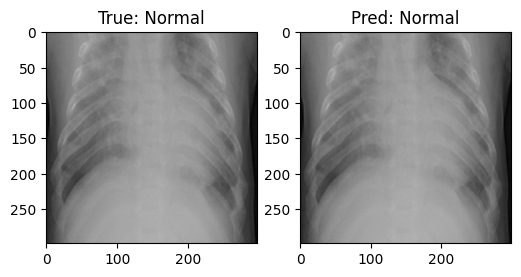

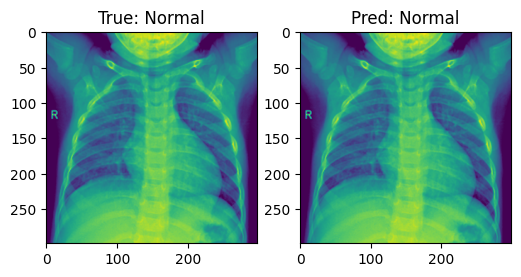

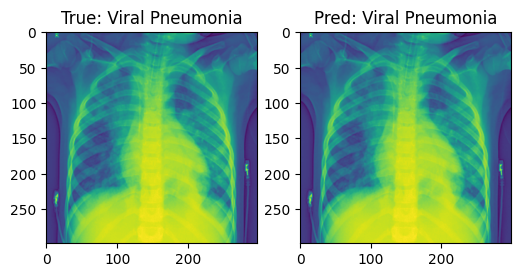

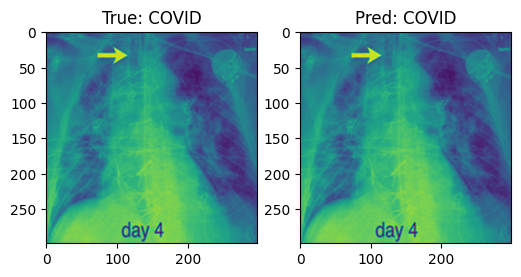

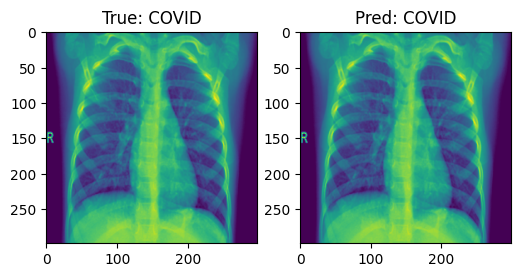

In [25]:
import random
import matplotlib.pyplot as plt

# Number of images to display
num_images = min(5, len(test_generator.filenames))

# Generate random indices
random_indices = random.sample(range(len(test_generator.filenames)), num_images)

# Visualize the randomly selected predictions
for idx in random_indices:
    plt.figure(figsize=(6, 4))
    img = plt.imread(test_generator.filepaths[idx])

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"True: {class_labels[true_classes[idx]]}")

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.title(f"Pred: {class_labels[predicted_classes[idx]]}")
    plt.show()


# Assessing Areas of Error in Identification

Confusion Matrix

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Initialize lists to collect true labels and predictions
true_classes = []
predicted_classes = []

# Predict on the entire test set
for images, labels in test_generator:
    # Append true labels
    true_classes.extend(np.argmax(labels, axis=1))
    # Predict and append predicted labels
    predictions = model.predict(images)
    predicted_classes.extend(np.argmax(predictions, axis=1))
    # Break after processing one batch to prevent infinite loop
    if len(true_classes) >= test_generator.samples:
        break

# Convert lists to numpy arrays
true_classes = np.array(true_classes)
predicted_classes = np.array(predicted_classes)

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
cm_df = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())

1/1 [==============================] - 17s 17s/step


Classification Report

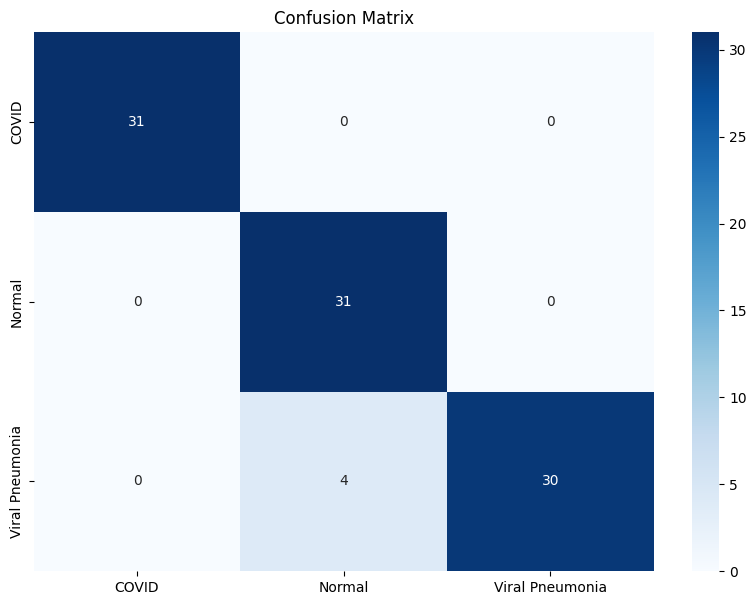

                 precision    recall  f1-score   support

          COVID       1.00      1.00      1.00        31
         Normal       0.89      1.00      0.94        31
Viral Pneumonia       1.00      0.88      0.94        34

       accuracy                           0.96        96
      macro avg       0.96      0.96      0.96        96
   weighted avg       0.96      0.96      0.96        96



In [19]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

Plot Accuracy and Loss

In [20]:
type(history)

keras.src.callbacks.History

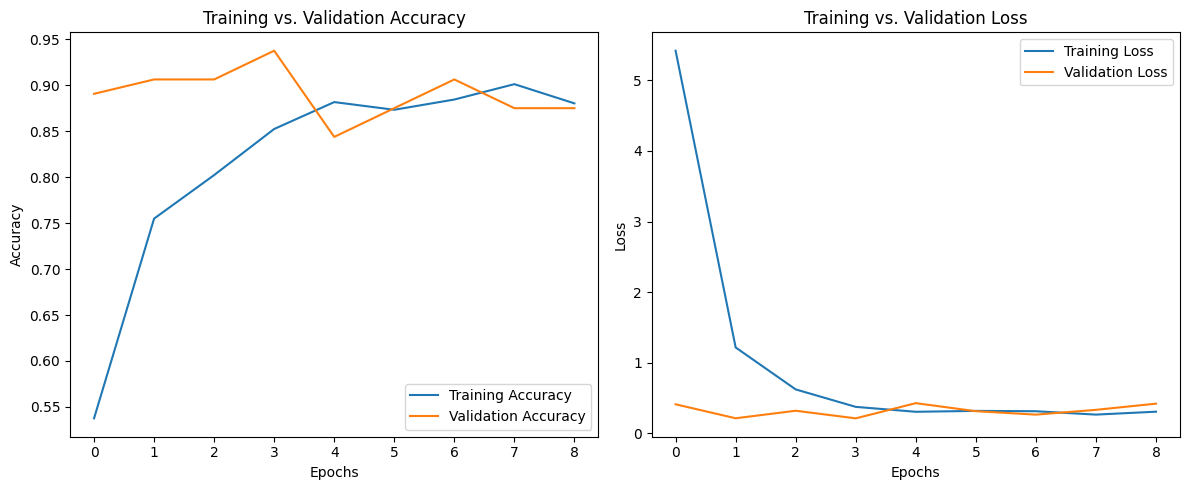

In [22]:
# Access history dictionary directly
history_dict = history.history

# Plot training and validation loss/accuracy curves
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
if 'accuracy' in history_dict and 'val_accuracy' in history_dict:
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
else:
    print("Accuracy or validation accuracy not found in history.")

# Plot loss
plt.subplot(1, 2, 2)
if 'loss' in history_dict and 'val_loss' in history_dict:
    plt.plot(history_dict['loss'], label='Training Loss')
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
else:
    print("Loss or validation loss not found in history.")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Export Classification Report to Excel

In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import random
import matplotlib.pyplot as plt

# Assuming you have true_classes and predicted_classes defined
# true_classes = ...
# predicted_classes = ...
# class_labels = ...

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Convert the report to a DataFrame
df_report = pd.DataFrame(report).transpose()

# Save the DataFrame to an Excel file
df_report.to_excel('classification_report.xlsx', index=True)


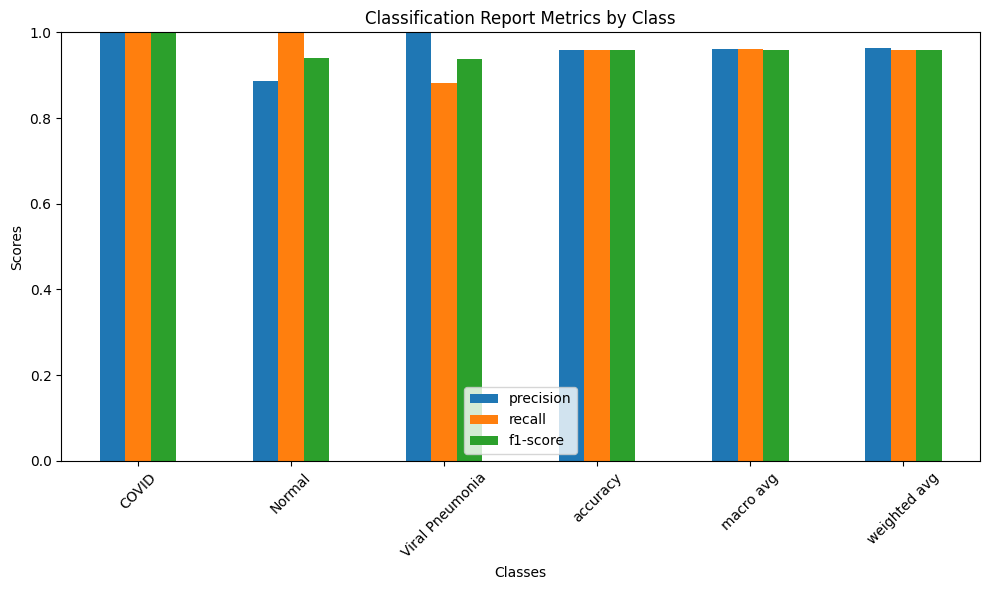

In [27]:
df_report = pd.DataFrame(report).transpose()

# Drop support column for plotting
df_plot = df_report.drop(columns=['support'])

# Plot the bar chart
df_plot[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Classification Report Metrics by Class')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.ylim(0, 1)
plt.xticks(np.arange(len(df_plot.index)), df_plot.index, rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()